<a href="https://colab.research.google.com/github/pachterlab/LP_2024/blob/main/bee_real_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import numpy as np
import pandas as pd
import random
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# Analysis of the data from Srinivasan et al (2000)
[https://www.science.org/doi/10.1126/science.287.5454.851](https://www.science.org/doi/10.1126/science.287.5454.851)

Reproduction of Figure 2 using data reported in Table 1 in the paper:

<ipython-input-2-9b7229806677>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(experiment, m*experiment + c, 'r', label='Fitted line', color="black")


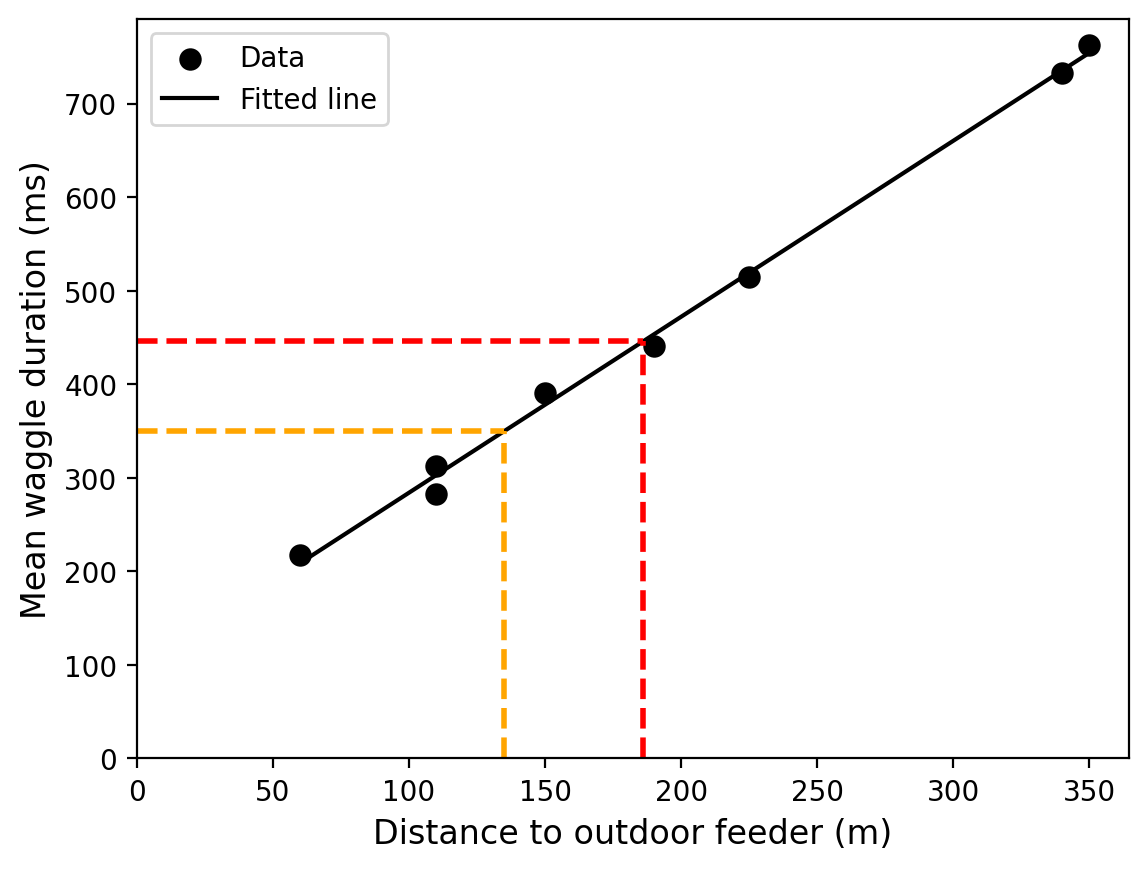

Slope (m): 1.8811934395719447
Intercept (c): 95.95850878213326
R-squared (r^2): 0.9966154402414593
186 m of outdoor flight corresponds to 445.860488542515 ms of mean waggle duration.
250 ms of mean waggle duration corresponds to 135.04272653410513 m of outdoor flight .


In [2]:
# Data from Table 1
experiment = np.array([60, 110, 110, 150, 190, 225, 340, 350])
mean_waggles = np.array([217.5, 283.0, 312.4, 390.9, 441.2, 514.4, 733.3, 762.6])

# Perform least squares regression
A = np.vstack([experiment, np.ones(len(experiment))]).T
m, c = np.linalg.lstsq(A, mean_waggles, rcond=None)[0]

# Calculate the predicted values
predicted_values = m * experiment + c

# Calculate the mean of the observed values
mean_observed = np.mean(mean_waggles)

# Calculate the total sum of squares (TSS)
tss = np.sum((mean_waggles - mean_observed) ** 2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((mean_waggles - predicted_values) ** 2)

# Calculate R-squared (coefficient of determination)
r_squared = 1 - (rss / tss)

# Plot the data and regression line
fontsize = 12
plt.scatter(experiment, mean_waggles, label='Data', color="black", s=50)
plt.plot(experiment, m*experiment + c, 'r', label='Fitted line', color="black")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('Distance to outdoor feeder (m)', fontsize=fontsize)
plt.ylabel('Mean waggle duration (ms)', fontsize=fontsize)
plt.legend()

# Add lines at 186m and 350ms
# Calculate y at 186m
y = m * 186 + c
plt.plot([0, 186], [y, y], color="red", ls="--", lw=2)
plt.plot([186, 186], [0, y], color="red", ls="--", lw=2)
# Calculate x at 350ms
x = (350 - c) / m
plt.plot([0, x], [350, 350], color="orange", ls="--", lw=2)
plt.plot([x, x], [0, 350], color="orange", ls="--", lw=2)

plt.savefig("fig2_reproduction.png", dpi=300, bbox_inches="tight")

plt.show()

# Print the slope (m), intercept (c), and R-squared (r^2)
print(f"Slope (m): {m}")
print(f"Intercept (c): {c}")
print(f"R-squared (r^2): {r_squared}")
print(f"186 m of outdoor flight corresponds to {y} ms of mean waggle duration.")
print(f"250 ms of mean waggle duration corresponds to {x} m of outdoor flight .")

Overlay the plot above by Srinivasan et al. with the data from Schürch et al 2019 (https://www.sciencedirect.com/science/article/pii/S000334721930017X):

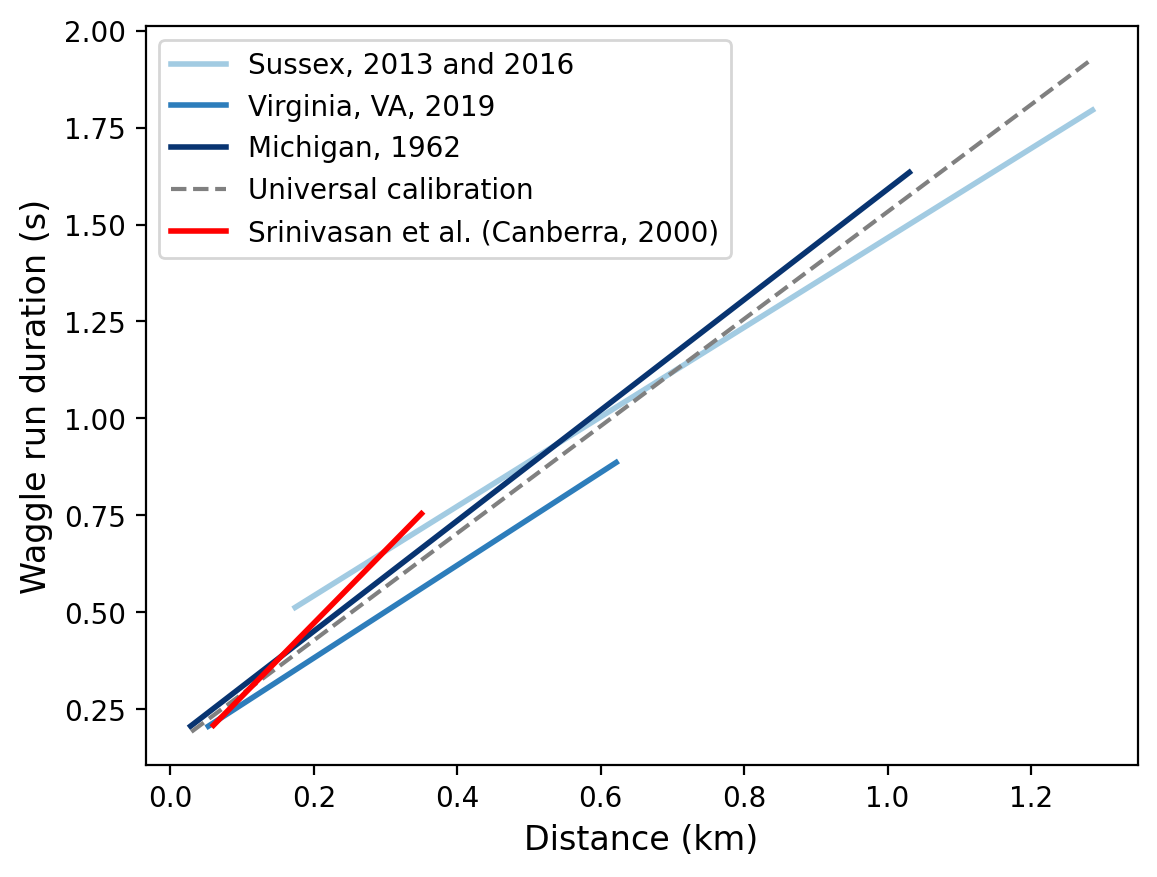

In [3]:
fig, ax = plt.subplots()
colors = ["#a2cbe2", "#2d7dbb", "#083471"]

# Data scraped from Schürch et al 2019 Figure 2 using WebPlotDigitizer (https://automeris.io/WebPlotDigitizer.html)
ax.plot([0.1739189473075295, 1.2857760471056743], [0.5127019695359771, 1.7949995889822907], color=colors[0], lw=2, label="Sussex, 2013 and 2016")
ax.plot([0.05278867904997059, 0.6215154070749849], [0.20641613868650976, 0.8863353356492416], color=colors[1], lw=2,label="Virginia, VA, 2019")
ax.plot([0.02812761643218359, 1.0303946074476409], [0.2066444818588966, 1.6344012689791243], color=colors[2], lw=2,label="Michigan, 1962")
ax.plot([0.02912380157891692, 1.2837179139785602], [0.1918204431075381, 1.9246482754001344], color="grey", ls="--", label="Universal calibration")

ax.plot(experiment/1000, np.array(m * experiment + c)/1000, color="red", lw=2, label="Srinivasan et al. (Canberra, 2000)")

ax.legend(fontsize=fontsize-2)
ax.set_xlabel('Distance (km)', fontsize=fontsize)
ax.set_ylabel('Waggle run duration (s)', fontsize=fontsize)

fig.savefig("universal_calibration.png", dpi=300, bbox_inches="tight")

fig.show()

Simulate correlations obtained by sampling from a Gaussian distribution with the mean and standard deviation values reported in the paper 100,000 times:

In [4]:
def simulate_r2(experiment, mean_waggles, std_deviation, trials, fr_correct=False):
  num_iterations = 100000

  # Initialize lists to store R-squared and simulated mean values
  r_squared_values = []
  means = []

  # Perform the iterations
  for _ in range(num_iterations):
    # Initialize an array to store sampled values
    sampled_values = np.zeros(len(experiment))

    # Sample values for each data point based on the number of trials
    for i in range(len(experiment)):
      num_samples = trials[i]
      samples = np.random.normal(mean_waggles[i], std_deviation[i], num_samples)

      if fr_correct:
        # Round each data point in the 'samples' array to the nearest number divisible by 40
        # to account for the detection limit of the camera (frame rate: 25 frames per second)
        samples = (np.ceil(samples / 40) -1 ) * 40

      sampled_values[i] = np.mean(samples)

    # Calculate the least squares regression
    A = np.vstack([experiment, np.ones(len(experiment))]).T
    m, c = np.linalg.lstsq(A, sampled_values, rcond=None)[0]

    # Calculate the predicted values
    predicted_values = m * experiment + c

    # Calculate the mean of the observed values
    mean_observed = np.mean(sampled_values)

    # Calculate the total sum of squares (TSS)
    tss = np.sum((sampled_values - mean_observed) ** 2)

    # Calculate the residual sum of squares (RSS)
    rss = np.sum((sampled_values - predicted_values) ** 2)

    # Calculate R-squared (coefficient of determination)
    r_squared = 1 - (rss / tss)

    # Append the R-squared value to the list
    r_squared_values.append(r_squared)

    # Append the simulated means to the list
    means.append(sampled_values)

  return r_squared_values, means

In [5]:
# Data from Table 1
experiment = np.array([60, 110, 110, 150, 190, 225, 340, 350])
mean_waggles = np.array([217.5, 283.0, 312.4, 390.9, 441.2, 514.4, 733.3, 762.6])
std_deviation = np.array([65.2, 66.0, 44.4, 62.5, 60.0, 74.8, 116.4, 129.4])

trials_bees = np.array([3,5,6,3,6,8,10,5,4,7])
trials_dances = np.array([10, 10, 14, 10, 7, 21, 23, 9, 9, 16])
trials_waggles = np.array([92,93,181,92,65,345,222,87,216,138])

Fraction of R-squared >= 0.997: 0.0056


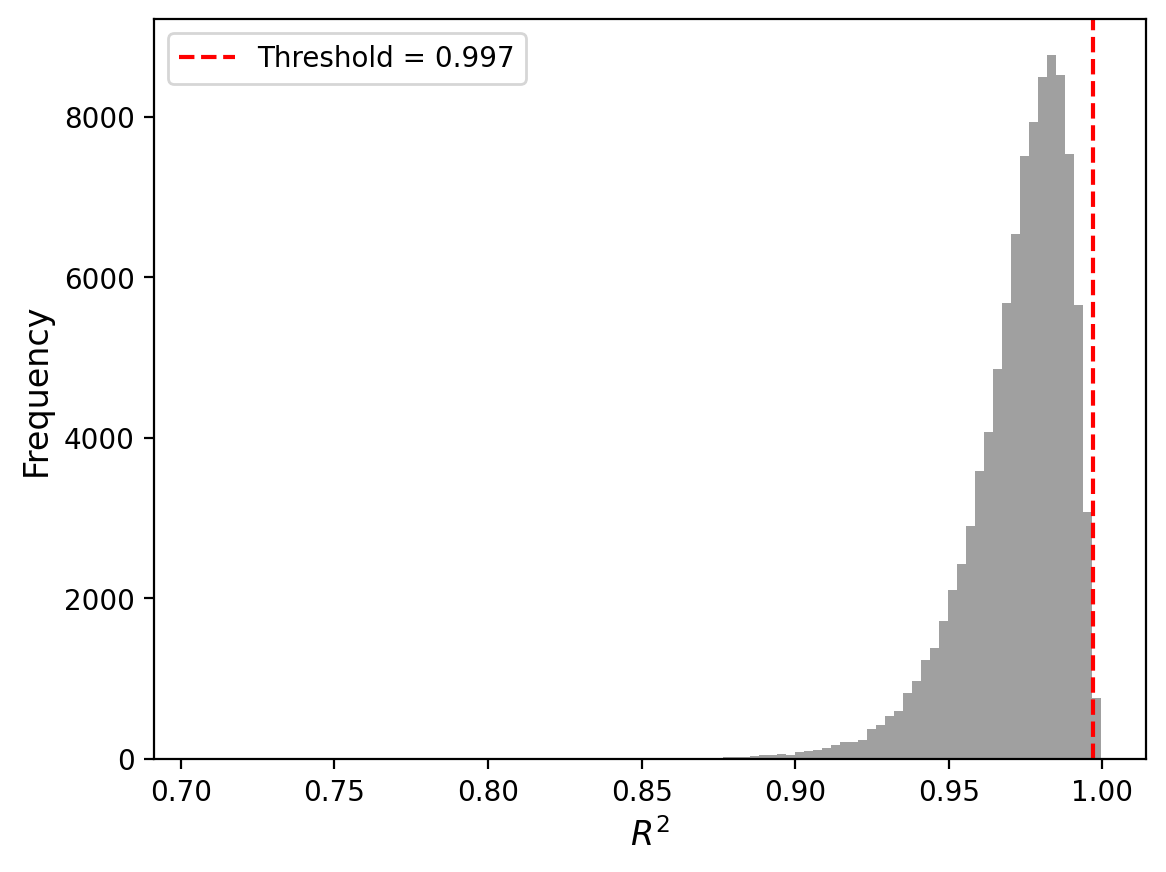

CPU times: user 33.1 s, sys: 973 ms, total: 34.1 s
Wall time: 42.4 s


In [6]:
%%time
# Simulate R2 values using the number of bees as replicates
r_squared_values, means_simulated = simulate_r2(experiment, mean_waggles, std_deviation, trials_bees, fr_correct=True)

# Plot a histogram of R-squared values
plt.hist(r_squared_values, bins=100, alpha=0.75, color="grey")
plt.xlabel('$R^2$', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)

# Calculate the fraction of R-squared values greater than 0.997
threshold = 0.997
fraction_above_threshold = np.mean(np.array(r_squared_values) >= threshold)
print(f'Fraction of R-squared >= {threshold}: {fraction_above_threshold:.4f}')

# Add a red vertical line at the threshold value
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()

plt.savefig("compute_r2_srinivasan.png", dpi=300, bbox_inches="tight")

plt.show()

CPU times: user 976 ms, sys: 19.9 ms, total: 996 ms
Wall time: 1.01 s


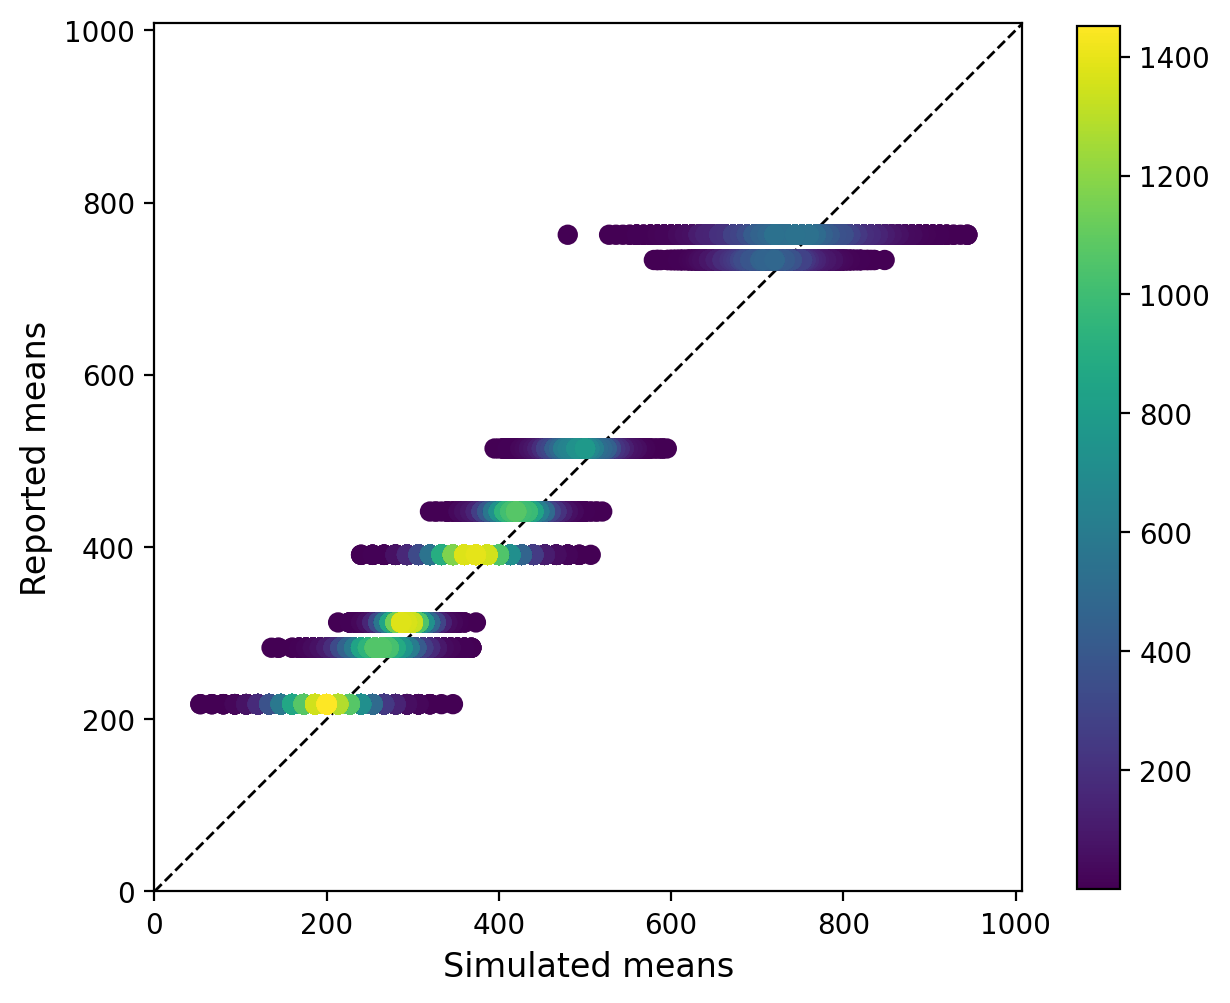

In [7]:
%%time
# Sanity check: Show that the simulated means are the same as reported means on average
fig, ax = plt.subplots(figsize=(7, 7))

def flatten(xss):
  """
  Flatten a list of lists.
  """
  return [x for xs in xss for x in xs]

# Plot the first n simulated means against the real data means
n = 10000

mean_waggles_dup = []
for i in range(n):
  mean_waggles_dup.append(mean_waggles)

x = np.array(flatten(means_simulated[:n]))
y = np.array(flatten(mean_waggles_dup))

# Histogram data to show point density
bins = [1500, 1500]
hh, locx, locy = np.histogram2d(x, y, bins=bins)
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]
scatter = ax.scatter(x2, y2, c=z2, cmap="viridis", s=40)

# Add colorbar
fig.colorbar(scatter, ax=ax, shrink=0.8)

ax.set_ylabel("Reported means", fontsize=fontsize)
ax.set_xlabel("Simulated means", fontsize=fontsize)

ax.set_ylim(0, np.max(means_simulated))
ax.set_xlim(0, np.max(means_simulated))

# Add x=y line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'black', zorder=0, ls="--", lw=1)
ax.set_aspect('equal')

fig.show()

Fraction of R-squared >= 0.997: 0.1953


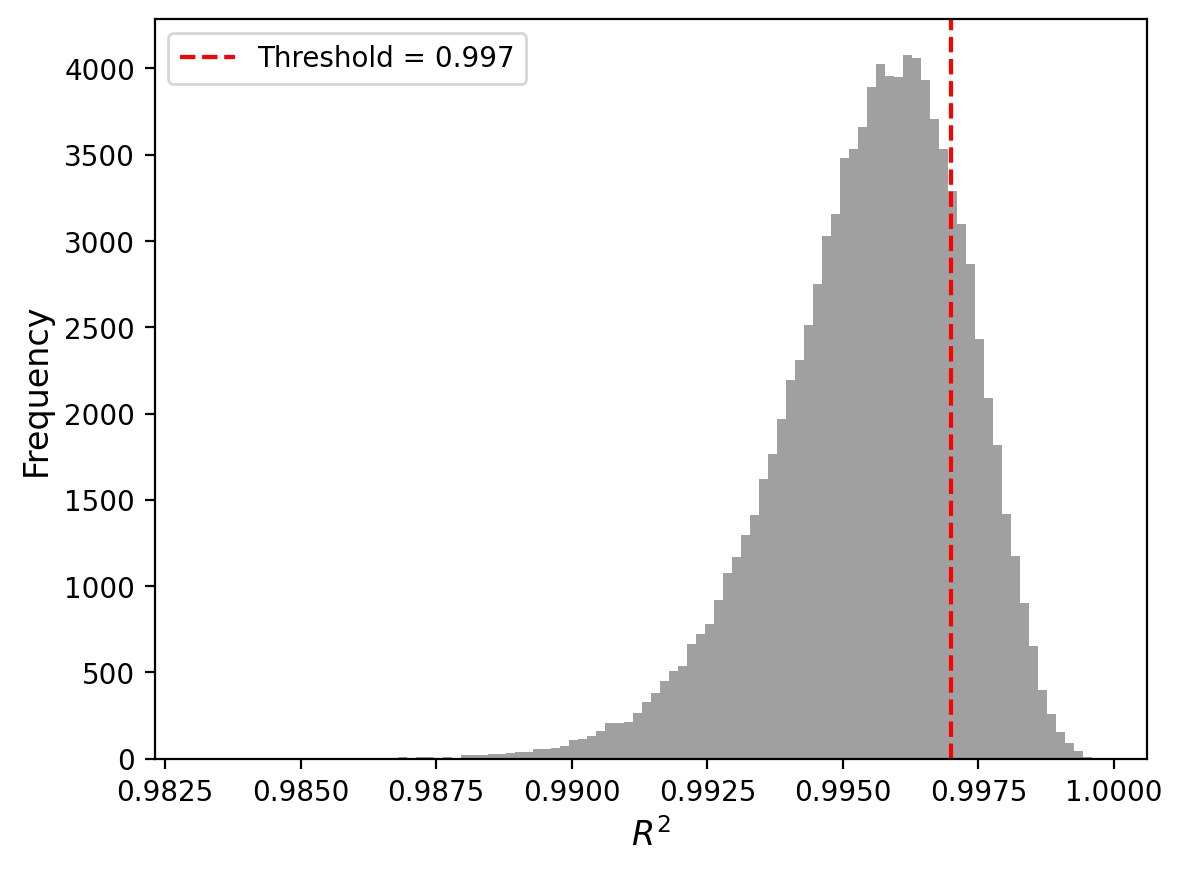

CPU times: user 33.9 s, sys: 414 ms, total: 34.3 s
Wall time: 34.2 s


In [8]:
%%time
# Simulate R2 values using the number of waggle dances as replicates
r_squared_values, _ = simulate_r2(experiment, mean_waggles, std_deviation, trials_waggles, fr_correct=True)

# Plot a histogram of R-squared values
plt.hist(r_squared_values, bins=100, alpha=0.75, color="grey")
plt.xlabel('$R^2$', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)

# Calculate the fraction of R-squared values greater than 0.997
threshold = 0.997
fraction_above_threshold = np.mean(np.array(r_squared_values) >= threshold)
print(f'Fraction of R-squared >= {threshold}: {fraction_above_threshold:.4f}')

# Add a red vertical line at the threshold value
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()

plt.savefig("compute_r2_srinivasan_wagtrials.png", dpi=300, bbox_inches="tight")

plt.show()

Plot the relationship between the reported standard deviation and mean values:

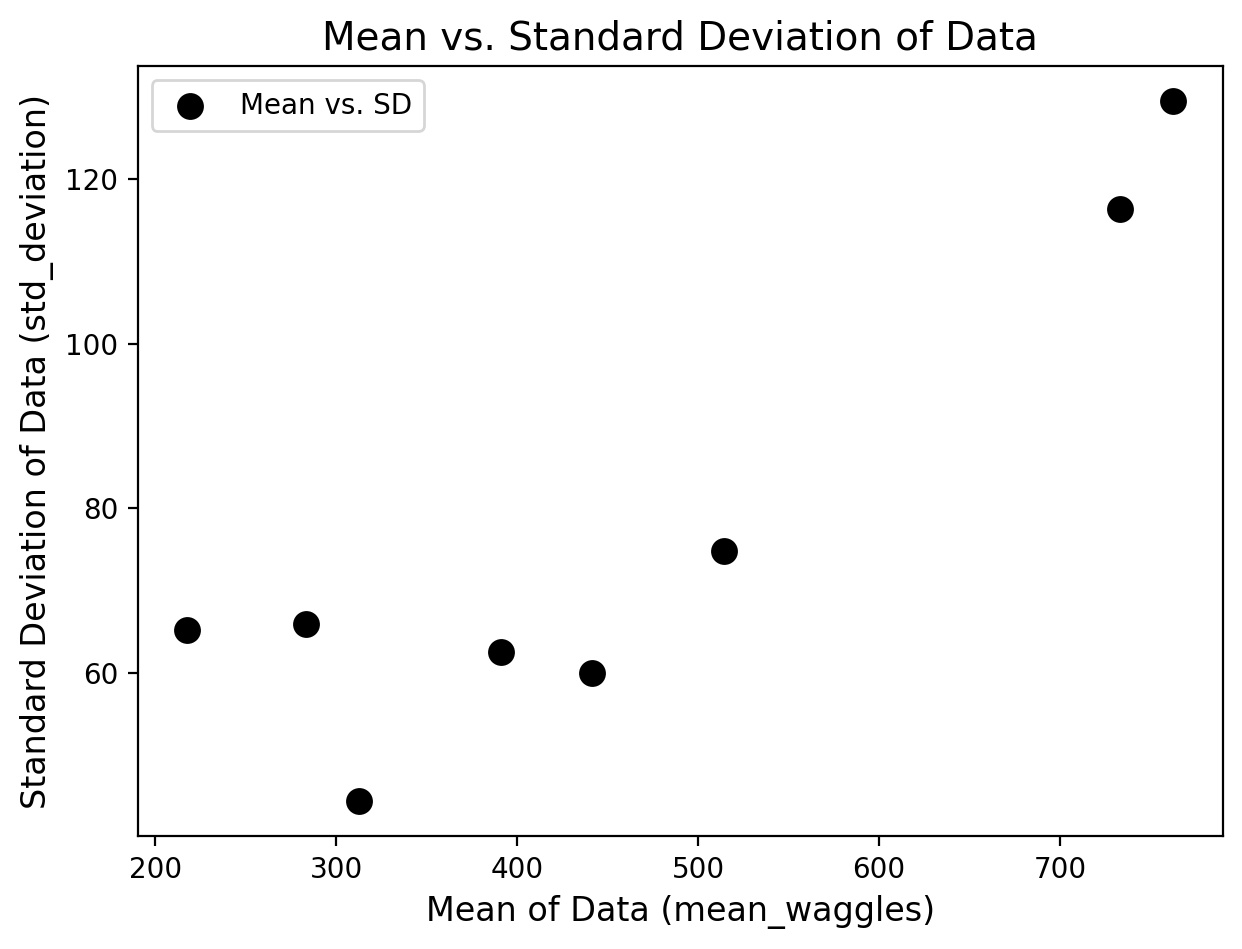

In [9]:
# Data from Table 1
mean_waggles = np.array([217.5, 283.0, 312.4, 390.9, 441.2, 514.4, 733.3, 762.6])
std_deviation = np.array([65.2, 66.0, 44.4, 62.5, 60.0, 74.8, 116.4, 129.4])

# Create a scatter plot of mean_waggles vs. std_deviation
plt.figure(figsize=(7, 5))
plt.scatter(mean_waggles, std_deviation, s=75, color='black', label='Mean vs. SD')

# Add labels and a legend
plt.xlabel('Mean of Data (mean_waggles)', fontsize=fontsize)
plt.ylabel('Standard Deviation of Data (std_deviation)', fontsize=fontsize)
plt.title('Mean vs. Standard Deviation of Data', fontsize=fontsize+2)
plt.legend()

# Show the plot
plt.show()

# Analysis of the data from Zhang et al (2005)
[https://www.pnas.org/doi/full/10.1073/pnas.0501440102](https://www.pnas.org/doi/full/10.1073/pnas.0501440102)

Reproduce Figure 1c and recalculate $R^2$:

In [10]:
# Data scraped from Figure 1c using WebPlotDigitizer (https://automeris.io/WebPlotDigitizer.html)
dat = pd.read_csv(io.StringIO('''
1.0801217038539552, 0.730442423039498
2.0334685598377282, 0.6358406715496667
2.3884381338742386, 0.5866421064352002
3.1288032454361048, 0.5684330023672706
4.964503042596348, 0.5544152744630072
6.424949290060853, 0.5490252557281656
8.77789046653144, 0.5182517052578582
11.374239350912779, 0.4769537244574399
'''), header=None)

dat

,0,1
0,1.080122,0.730442
1,2.033469,0.635841
2,2.388438,0.586642
3,3.128803,0.568433
4,4.964503,0.554415
5,6.424949,0.549025
6,8.777890,0.518252
7,11.374239,0.476954


Parameters (a, b): [ 0.3737119  -0.49762674]
R-squared: 0.918198978181298


<ipython-input-11-0989fa8d0a2a>:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x_smooth, y_smooth+0.5, 'r', label='Smooth Fitted Curve', color="black")


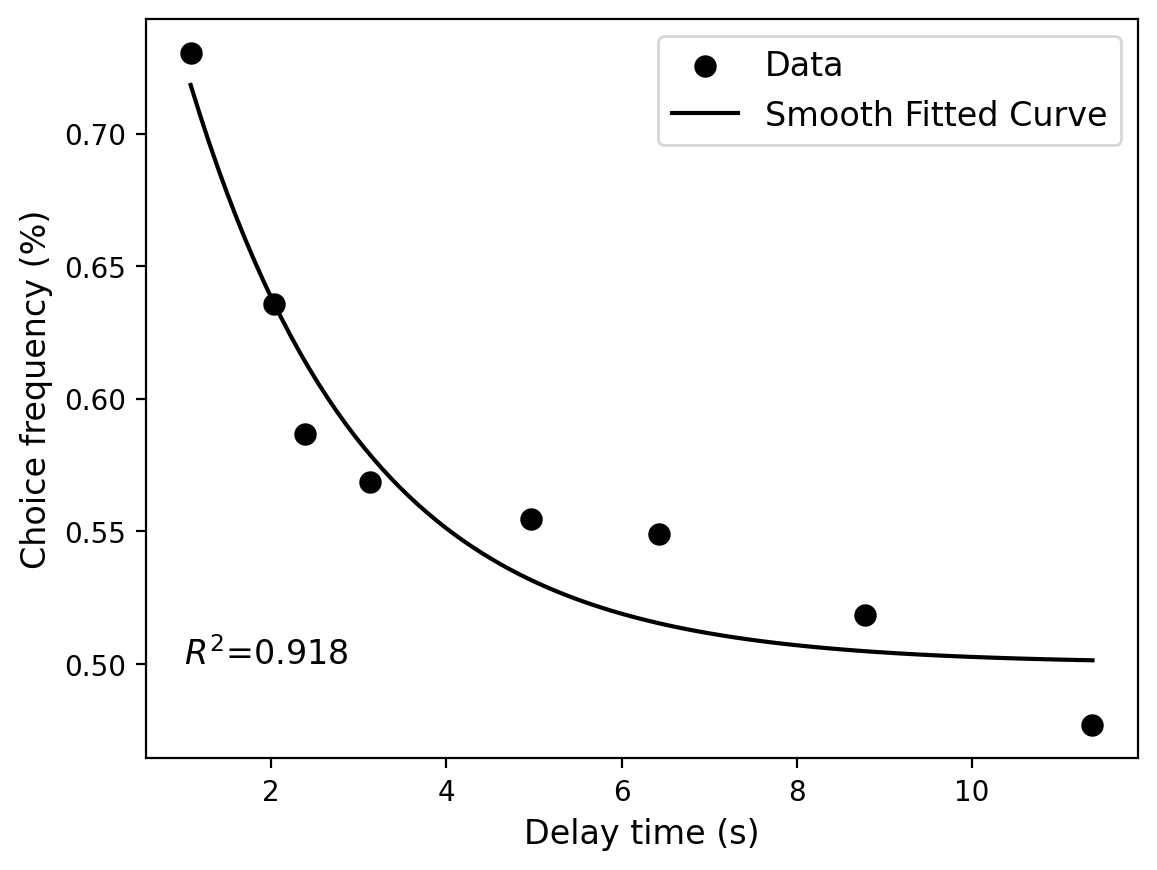

In [11]:
# Define the exponential function
def exponential(x, a, b):
    return a * np.exp(b * x)

# Extract the x and y values from the DataFrame
x_data = dat[0]
y_data = dat[1]-0.5

# Fit the new data to the exponential function
params, covariance = curve_fit(exponential, x_data, y_data)

# Generate a continuous range of x-values for the smooth curve
x_smooth = np.linspace(min(x_data), max(x_data), 100)

# Calculate the corresponding y-values for the smooth curve
y_smooth = exponential(x_smooth, *params)

# Calculate the R-squared value
# First, calculate the predicted values
y_fit = exponential(x_data, *params)

# Calculate the total sum of squares (TSS)
TSS = np.sum((y_data - np.mean(y_data))**2)

# Calculate the residual sum of squares (RSS)
RSS = np.sum((y_data - y_fit)**2)

# Calculate R-squared
R_squared = 1 - (RSS / TSS)

# Print the parameters of the exponential function and R-squared value
print("Parameters (a, b):", params)
print("R-squared:", R_squared)

# Plot the new data and the smooth fitted curve
plt.scatter(x_data, y_data+0.5, label='Data', color="black", s=50)
plt.plot(x_smooth, y_smooth+0.5, 'r', label='Smooth Fitted Curve', color="black")
plt.xlabel('Delay time (s)', fontsize=fontsize)
plt.ylabel('Choice frequency (%)', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.text(1, 0.5, f"$R^2$={'{:,}'.format(np.round(R_squared, 3))}", fontsize=fontsize)

plt.savefig("zhang_exp_r2.png", dpi=300, bbox_inches="tight")

plt.show()

Simulate correlations obtained by sampling from a Gaussian distribution with the mean and standard deviation values reported in the paper 100,000 times:

In [12]:
# Data from the table in Fig. 1b
distance = np.array([25,75,125,175,275,375,475,575])
time = np.array([1.24,2.17,2.52,3.26,5.06,6.53,8.86,11.41])
sem = np.array([0.1,0.13,0.13,0.19,0.32,0.86,1.23,1.69])

# Since the authors here report standard error of the mean (instead of standard deviation),
# we are setting the number of trials to 1 instead of to the number of replicates
replicates = np.array([1,1,1,1,1,1,1,1])

<ipython-input-13-4f62b4e78fcb>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(distance, m* distance + c, 'r', label='Fitted line', color="black", lw=2)


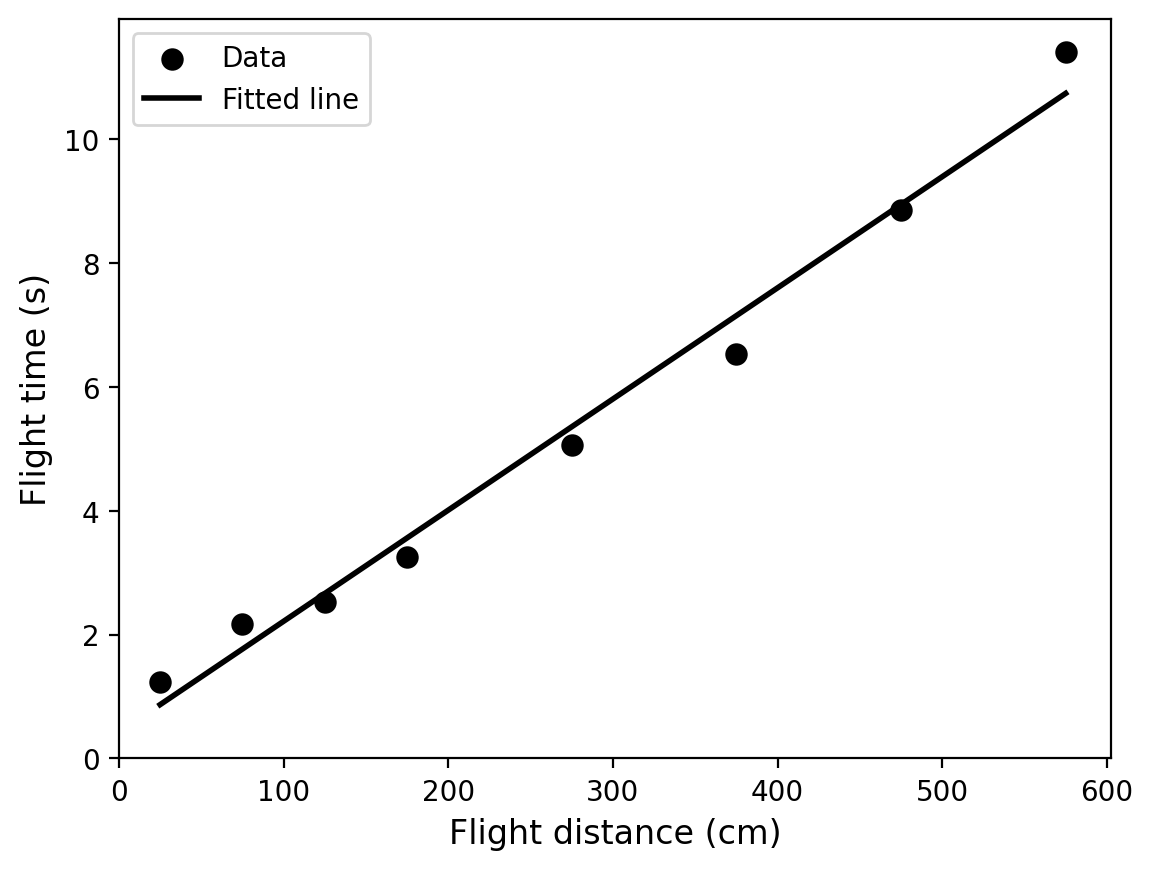

Slope (m): 0.017947488584474883
Intercept (c): 0.42003424657534316
R-squared (r^2): 0.9850240246964438


In [13]:
# Reproduce correlation shown in Fig. 1b
# Perform least squares regression
A = np.vstack([distance, np.ones(len(distance))]).T
m, c = np.linalg.lstsq(A, time, rcond=None)[0]

# Calculate the predicted values
predicted_values = m * distance + c

# Calculate the mean of the observed values
mean_observed = np.mean(time)

# Calculate the total sum of squares (TSS)
tss = np.sum((time - mean_observed) ** 2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((time - predicted_values) ** 2)

# Calculate R-squared (coefficient of determination)
r_squared = 1 - (rss / tss)

# Plot the data and regression line
fontsize = 12
plt.scatter(distance, time, label='Data', color="black", s=50)
plt.plot(distance, m* distance + c, 'r', label='Fitted line', color="black", lw=2)
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlabel('Flight distance (cm)', fontsize=fontsize)
plt.ylabel('Flight time (s)', fontsize=fontsize)
plt.legend()

plt.show()

# Print the slope (m), intercept (c), and R-squared (r^2)
print(f"Slope (m): {m}")
print(f"Intercept (c): {c}")
print(f"R-squared (r^2): {r_squared}")

Fraction of R-squared >= 0.985: 0.1466


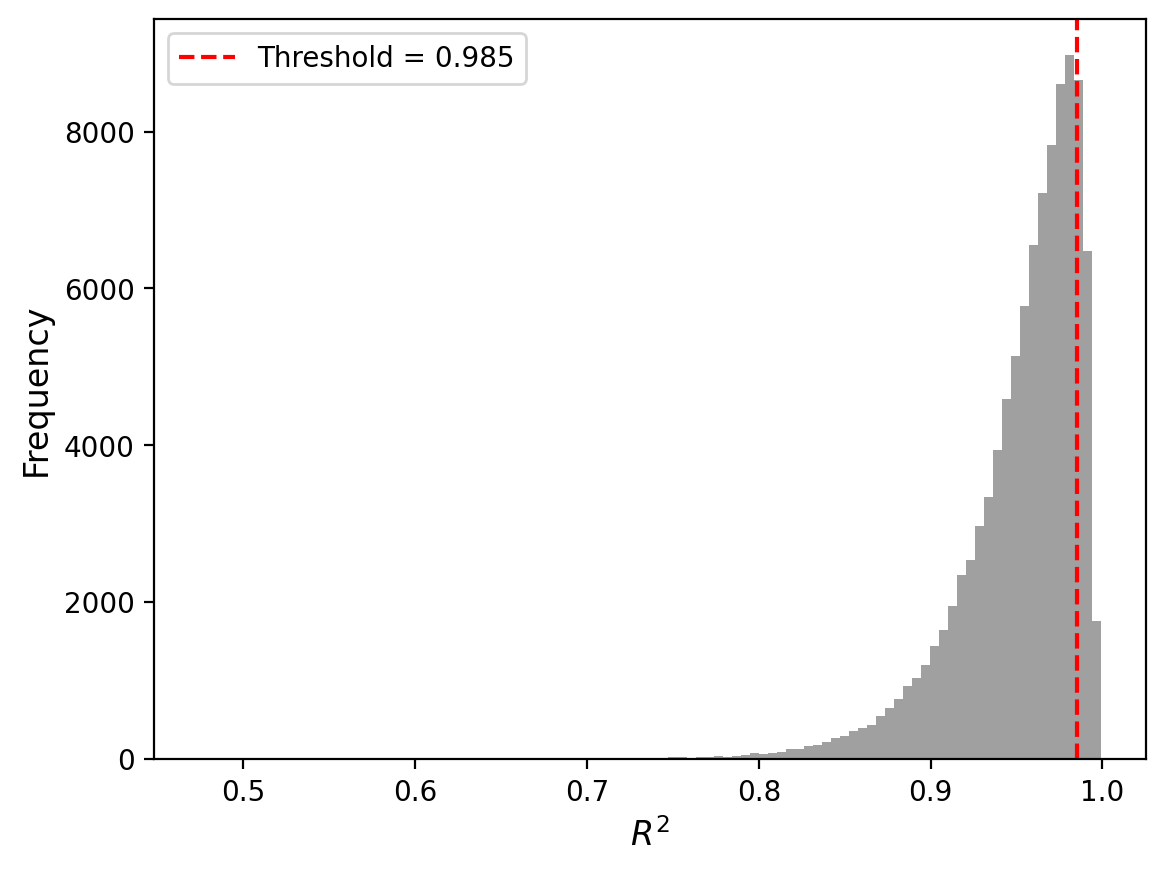

CPU times: user 19.3 s, sys: 869 ms, total: 20.2 s
Wall time: 19.8 s


In [14]:
%%time
# Simulate R2 values
r_squared_values, _ = simulate_r2(distance, time, sem, replicates)

# Plot a histogram of R-squared values
plt.hist(r_squared_values, bins=100, alpha=0.75, color="grey")
plt.xlabel('$R^2$', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)

# Calculate the fraction of R-squared values greater than 0.985
threshold = 0.985
fraction_above_threshold = np.mean(np.array(r_squared_values) >= threshold)
print(f'Fraction of R-squared >= {threshold}: {fraction_above_threshold:.4f}')

# Add a red vertical line at the threshold value
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()

plt.savefig("compute_r2_zhang.png", dpi=300, bbox_inches="tight")

plt.show()